# Molecular Mechanics Parameters for a Protein-Ligand Complex

In this exercise, we will build molecular mechanics models of the adenosine receptor A2A (ADORA2A) with a variety of ligands that have different signaling efficacy ($E_{max}$). $EC_{50}$ describes the amount of ligand required to induce a response. $E_{max}$ describes the strength of a cellular response at a saturating concentration of ligand. The same ligand can have different pharmacodynamic properties for different pathways, for example with different G proteins through the $\mu$ opioid receptor [1].

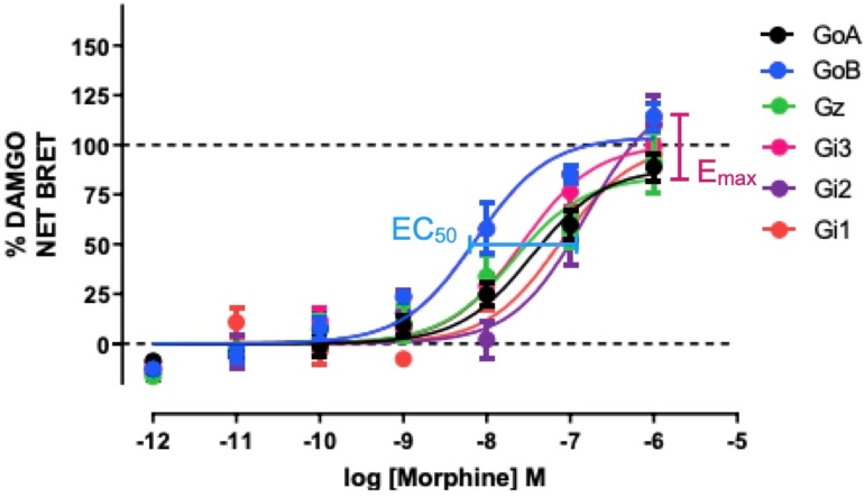

Fig. 1. G protein signaling of morphine at the MOR.

[1] Malcolm, N. J.; Palkovic, B.; Sprague, D. J.; Calkins, M. M.; Lanham, J. K.; Halberstadt, A. L.; Stucke, A. G.; McCorvy, J. D. Mu-Opioid Receptor Selective Superagonists Produce Prolonged Respiratory Depression. iScience 2023, 26 (7), 107121. https://doi.org/10.1016/j.isci.2023.107121.

I would like us to study the mechanisms of signal activation. Guo et al [2] found that the efficacy of a number of ADORA2A ligands is highly correlated with the logarithm of the residence time ($t_r$ = 1/k$_{off}$). My group recently found that the efficacy of a number of MOR ligands is highly correlated with the equilibrium probability of intracellular pocket conformations observed in molecular dynamics simulations [3]. I would like to evaluate whether efficacy of ADORA2A ligands is *also* correlated with the equilibrium probability of intracellular pocket conformations. In this exercise, we will build models of ADORA2A with different ligands. In subsequent exercises, we will perform and analyze molecular dynamics simulations with enhanced sampling.

We will use Bridgeport, a package being developed by research group that wraps multiple other packages to perform these tasks for different types of ligands. In addition to preparing small molecule ligands that are already in the provided PDB structure, it can prepare analogs of these ligands. It is also meant to prepare peptide and peptidomimetics.

[2] Guo, D.; Mulder‐Krieger, T.; IJzerman, A. P.; Heitman, L. H. Functional Efficacy of Adenosine A 2A Receptor Agonists Is Positively Correlated to Their Receptor Residence Time. British J Pharmacology 2012, 166 (6), 1846–1859. https://doi.org/10.1111/j.1476-5381.2012.01897.x.

[3] Cooper, D. A.; DePaolo-Boisvert, J.; Nicholson, S. A.; Gad, B.; Minh, D. D. L. Intracellular Pocket Conformations Determine Signaling through the μ Opioid Receptor. bioRxiv April 3, 2024. https://doi.org/10.1101/2024.04.03.588021.

When you are done with this exercise, save it under `Chem456-2024F/exercises` on Google Drive. It will be graded as satisfactory or unsatisfactory based on correctly completing the sections after `-->`. Do not remove the symbol `-->`.

# Part 0 - Setting up the Colab instance

### Installation on Google Colab

The following code cells will install all required packages, if you are working on [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb). Installing the [condacolab](https://github.com/jaimergp/condacolab) package will restart the kernel.

In [1]:
try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install_mambaforge()
except ModuleNotFoundError:
    pass

✨🍰✨ Everything looks OK!


--> The following cell downloads Bridgeport and install its dependencies. One of these is UCSF modeller, which performs homology modeling. You should obtain an academic license and replace the variable `modeller_license`.

In [2]:
!git clone https://github.com/CCBatIIT/Bridgeport.git
%cd Bridgeport
!git checkout 3ef7185 # Specific version that this notebook is designed for
%cd ..

try:
    import condacolab
    condacolab.check()
    !mamba install -c conda-forge openff-toolkit mdanalysis pdbfixer openbabel pdb2pqr prody py3dmol
    !mamba install -c salilab modeller=10.6

    modeller_dir = '/usr/local/lib/modeller-10.6'
    modeller_config = modeller_dir + '/modlib/modeller/config.py'
    modeller_license = ''

    F = open(modeller_config,'w')
    F.write("install_dir = r'" + modeller_dir + "'\n")
    F.write("license = r'" + modeller_license + "'\n")
    F.close()
except ModuleNotFoundError:
    on_colab = False
else:
    #check if installation was succesful
    try:
        import mdtraj, pdbfixer, openbabel, pdb2pqr, modeller
        on_colab = True
        from IPython.display import clear_output
        clear_output()  # clear the excessive installation outputs
        print("Dependencies successfully installed!")
    except ModuleNotFoundError:
        print("Error while installing dependencies!")

Dependencies successfully installed!


In [3]:
# Mount Google Drive
import os
if on_colab and (not os.path.isdir('/content/drive')):
  from google.colab import drive
  drive.mount('/content/drive')

In [4]:
# Creates input and working directories
directories = {'input':'bridgeport_in', \
               'working':'bridgeport_working'}

import os
if not os.path.isdir(directories['input']):
  os.mkdir(directories['input'])
if not os.path.isdir(directories['working']):
  os.mkdir(directories['working'])
  os.mkdir(os.path.join(directories['working'], 'ligands'))
  os.mkdir(os.path.join(directories['working'], 'proteins'))
  os.mkdir(os.path.join(directories['working'], 'aligned_input_pdb'))

# Part I - Building a structural model of the protein

We will build protein structural models using UCSF MODELLER. High-resolution crystal structures of ADORA2A in complex with many ligands are available in the PDB. All of the ligands described in Guo *et. al.* [2] or close analogs are represented. The crystal structures contain conformations of the orthosteric binding site that are appropriate for binding the specific ligands. Homology modelling is needed because of missing atoms and residues and because of mutations that were engineered to increase thermal or crystallographic stability. For example, [PDB entry 5wf5 contains an domain inserted from another protein, endolysin](https://www.rcsb.org/sequence/5WF5).

We will prepare homology models of ADORA2A using two templates. Primary templates will be high-resolution crystallographic structures. The secondary template will be an AlphaFold 2 model. In our current application, it is advantageous to model most of the protein based on a single structure to preserve the conformation of the active site. [The AlphaFold 2 model](https://alphafold.ebi.ac.uk/entry/P29274) provides reasonable structures of most the missing loops and tails.

## Target sequence

The full sequence of ADORA2A is available under UniProt entry [P29274](https://www.uniprot.org/uniprotkb/P29274/entry#sequences). The [AlphaFold 2 structure](https://alphafold.ebi.ac.uk/entry/P29274) has low confidence in the first four residues of the N terminus and beyond residue 313 in the C terminus; [nearly all high-resolution structures were based on constructs containing residues 1-317 or less.](https://www.uniprot.org/uniprotkb/P29274/entry#structure) Thus, we will model residues 1-313. The following code writes this sequence in a PIR file that UCSF Modeller can read.

In [5]:
receptor_name = 'ADORA2A'
PIR = f""">P1;{receptor_name}
sequence:{receptor_name}::::::::
MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSLAAADIAVGVLAI
PFAITISTGFCAACHGCLFIACFVLVLTQSSIFSLLAIAIDRYIAIRIPLRYNGLVTGTR
AKGIIAICWVLSFAIGLTPMLGWNNCGQPKEGKNHSQGCGEGQVACLFEDVVPMNYMVYF
NFFACVLVPLLLMLGVYLRIFLAARRQLKQMESQPLPGERARSTLQKEVHAAKSLAIIVG
LFALCWLPLHIINCFTFFCPDCSHAPLWLMYLAIVLSHTNSVVNPFIYAYRIREFRQTFR
KIIRSHVLRQQEPFKAAGTSA*"""

F = open(f"{directories['input']}/{receptor_name}.pir",'w')
F.write(PIR)
F.close()

## Template structures

We will download three protein structures from several sources: the PDB, the AlphaFold structural database, and the [Orientation of Proteins in Membranes (OPM) database](https://opm.phar.umich.edu/proteins/2808). OPM provides information about where the protein should be placed into the membrane.

--> Look up the [class spreadsheet](https://docs.google.com/spreadsheets/d/1WCEDId_oOeYVBFLX52qu_BYTnX7MLN8B5kDi3joZQ-g/edit?usp=sharing) to see which ligand you will model and your primary template. Modify the variable `template1_id` to match your PDB ID.

In [6]:
template1_id = "5wf5"
template2_id = "P29274"
opm_id = "4uhr"
template1_url = f"https://files.rcsb.org/download/{template1_id}.pdb"
template2_url = f"https://alphafold.ebi.ac.uk/files/AF-{template2_id}-F1-model_v4.pdb"
opm_url = f"https://opm-assets.storage.googleapis.com/pdb/{opm_id}.pdb"

import requests
for (id, url) in [(template1_id, template1_url), (template2_id, template2_url), (opm_id, opm_url)]:
  path = f"{directories['input']}/{id}.pdb"
  if not os.path.isfile(path):
    r = requests.get(url)
    r.raise_for_status()
    with open(path, "wb") as f:
        f.write(r.content)
  else:
    print(f"{path} has already been downloaded")

bridgeport_in/5wf5.pdb has already been downloaded
bridgeport_in/P29274.pdb has already been downloaded
bridgeport_in/4uhr.pdb has already been downloaded


## Sequence alignment

UCSF MODELLER needs to know how the target sequence and sequences in the structural templates are aligned. The following code creates and displays the alignment file. You should check the alignment to confirm that it makes sense.

In [7]:
%cd {directories['input']}
import modeller
env = modeller.Environ()
aln = modeller.Alignment(env)
aln.append(file=f"{receptor_name}.pir",align_codes=(receptor_name))
m = modeller.Model(env, file=f"{template1_id}.pdb")
aln.append_model(m, align_codes=template1_id)
m = modeller.Model(env, file=f"{template2_id}.pdb")
aln.append_model(m, align_codes=template2_id)
m = modeller.Model(env, file=f"{opm_id}.pdb")
aln.append_model(m, align_codes=opm_id)
aln.malign()
aln.write(file=f"{receptor_name}.ali", alignment_format='PIR')
aln.write(file=f"{receptor_name}.pap", alignment_format='PAP')
with open(f"{receptor_name}.pap",'r') as F:
  print('\n' + F.read())
%cd ..

/content/bridgeport_in

                         MODELLER 10.6, 2024/10/17, r12888

     PROTEIN STRUCTURE MODELLING BY SATISFACTION OF SPATIAL RESTRAINTS


                     Copyright(c) 1989-2024 Andrej Sali
                            All Rights Reserved

                             Written by A. Sali
                               with help from
              B. Webb, M.S. Madhusudhan, M-Y. Shen, G.Q. Dong,
          M.A. Marti-Renom, N. Eswar, F. Alber, M. Topf, B. Oliva,
             A. Fiser, R. Sanchez, B. Yerkovich, A. Badretdinov,
                     F. Melo, J.P. Overington, E. Feyfant
                 University of California, San Francisco, USA
                    Rockefeller University, New York, USA
                      Harvard University, Cambridge, USA
                   Imperial Cancer Research Fund, London, UK
              Birkbeck College, University of London, London, UK


Kind, OS, HostName, Kernel, Processor: 4, Linux 04ce15af2d15 6.1.85+ x86_64
Date and t

## Homology modeling

Now we will run UCSF MODELLER.

In [8]:
%cd {directories['input']}
import modeller.automodel
a = modeller.automodel.AutoModel(env, sequence=receptor_name, \
  knowns=(template1_id,template2_id), \
  alnfile=f'{receptor_name}.ali')
a.starting_model = 1
a.ending_model = 1
a.make()
%cd ..

/content/bridgeport_in

check_ali___> Checking pairwise structural superpositions. 

Equivalent CA pairs with distance difference larger than  6.0 angstroms:

ALN_POS TMPL1 TMPL2  RID1  RID2  NAM1  NAM2     DIST
----------------------------------------------------
      3     1     2    3     3      I     I    6.186
    157     1     2  157   157      Q     Q    8.350
    207     1     2  207   207      Q     Q    7.632
    312     1     2 1105   210      Q     Q   16.300
    313     1     2 1106   211      M     M   17.994
    314     1     2 1107   212      G     E   20.841
    315     1     2 1108   213      E     S   19.051
    316     1     2 1109   214      T     Q   19.054
    317     1     2 1110   215      G     P   15.549
    318     1     2 1111   216      V     L   11.433
    319     1     2 1112   217      A     P   17.444
    320     1     2 1113   218      G     G   20.709
    366     1     2 1159   219      D     E    8.265
    367     1     2 1160   220      A     R   

In [9]:
!cp {directories['input']}/{receptor_name}.B99990001.pdb {directories['input']}/{receptor_name}.pdb

## Structural alignment and visualization

To facilitate visualization and placement of the ligand, we will align all the templates and the final homology model to the OPM structure. Mapping will be based on the multiple sequence alignment and structural alignment will be based on the alpha carbons.

In [10]:
import prody

MSA = prody.parseMSA(f"{directories['input']}/{receptor_name}.ali")

# Load the OPM structure. Remove DUMMY atoms because prody doesn't like thme.
!grep ATOM {directories['input']}/{opm_id}.pdb > {directories['input']}/{opm_id}_atom.pdb
prody_target = prody.parsePDB(f"{directories['input']}/{opm_id}_atom.pdb")
opm_resnums = MSA[opm_id].getResnums(gaps=True)

for mobile in [template1_id, template2_id, receptor_name]:
  prody_mobile = prody.parsePDB(f"{directories['input']}/{mobile}.pdb")
  mobile_resnums = MSA[mobile].getResnums(gaps=True)
  # Use the MSA to create a mappiing
  mobile_inds = []
  opm_inds = []
  for (mobile_res, opm_res) in zip(mobile_resnums, opm_resnums):
    if mobile_res is None or opm_res is None:
      continue
    mobile_inds.append(prody_mobile.select(f'resindex {mobile_res-1} and name CA').getIndices()[0])
    opm_inds.append(prody_target.select(f'resindex {opm_res-1} and name CA').getIndices()[0])
  mobile_map = prody.AtomMap(prody_mobile, mobile_inds)
  opm_map = prody.AtomMap(prody_target, opm_inds)
  # Calculate and apply the transformation
  transformation = prody.calcTransformation(mobile_map, opm_map)
  prody.applyTransformation(transformation, prody_mobile)
  prody.writePDB(f"{directories['input']}/{mobile}_aligned.pdb", prody_mobile)

@> 4 sequence(s) with 560 residues were parsed in 0.00s.
@> 2401 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Cannot parse start and end values from sequence label 4uhr. Setting resnums 1 to 310
@> 3548 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> Cannot parse start and end values from sequence label 5wf5. Setting resnums 1 to 444
@> WARNING mobile is an AtomMap instance, consider assign weights=mobile.getFlags("mapped") if there are dummy atoms in mobile
@> WARNING target is an AtomMap instance, consider assign weights=target.getFlags("mapped") if there are dummy atoms in target
@> 3145 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> Cannot parse start and end values from sequence label P29274. Setting resnums 1 to 412
@> WARNING mobile is an AtomMap instance, consider assign weights=mobile.getFlags("mapped") if there are dummy atoms in mobile
@> WARNING target is an AtomMap instance, consider assign weights=target.getFlags("mapped") if there are dummy atoms

In [11]:
# Visualizes aligned structures
import py3Dmol
view = py3Dmol.view()
view.setBackgroundColor('white')
view.addModel(open(f"{directories['input']}/{template1_id}_aligned.pdb", 'r').read(),'pdb')
view.addModel(open(f"{directories['input']}/{template2_id}_aligned.pdb", 'r').read(),'pdb')
view.addModel(open(f"{directories['input']}/{opm_id}_atom.pdb", 'r').read(),'pdb')
view.addModel(open(f"{directories['input']}/{receptor_name}_aligned.pdb", 'r').read(),'pdb')
view.setStyle({'model':0}, {'cartoon': {'color':'blue'}})
view.setStyle({'model':1}, {'cartoon': {'color':'yellow'}})
view.setStyle({'model':2}, {'cartoon': {'color':'green'}})
view.setStyle({'model':3}, {'cartoon': {'color':'purple'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

--> Describe the differences between the templates and the final homology model.

# Part II - Preparing ligands

These are the ligands from Guo et. al. [2]:

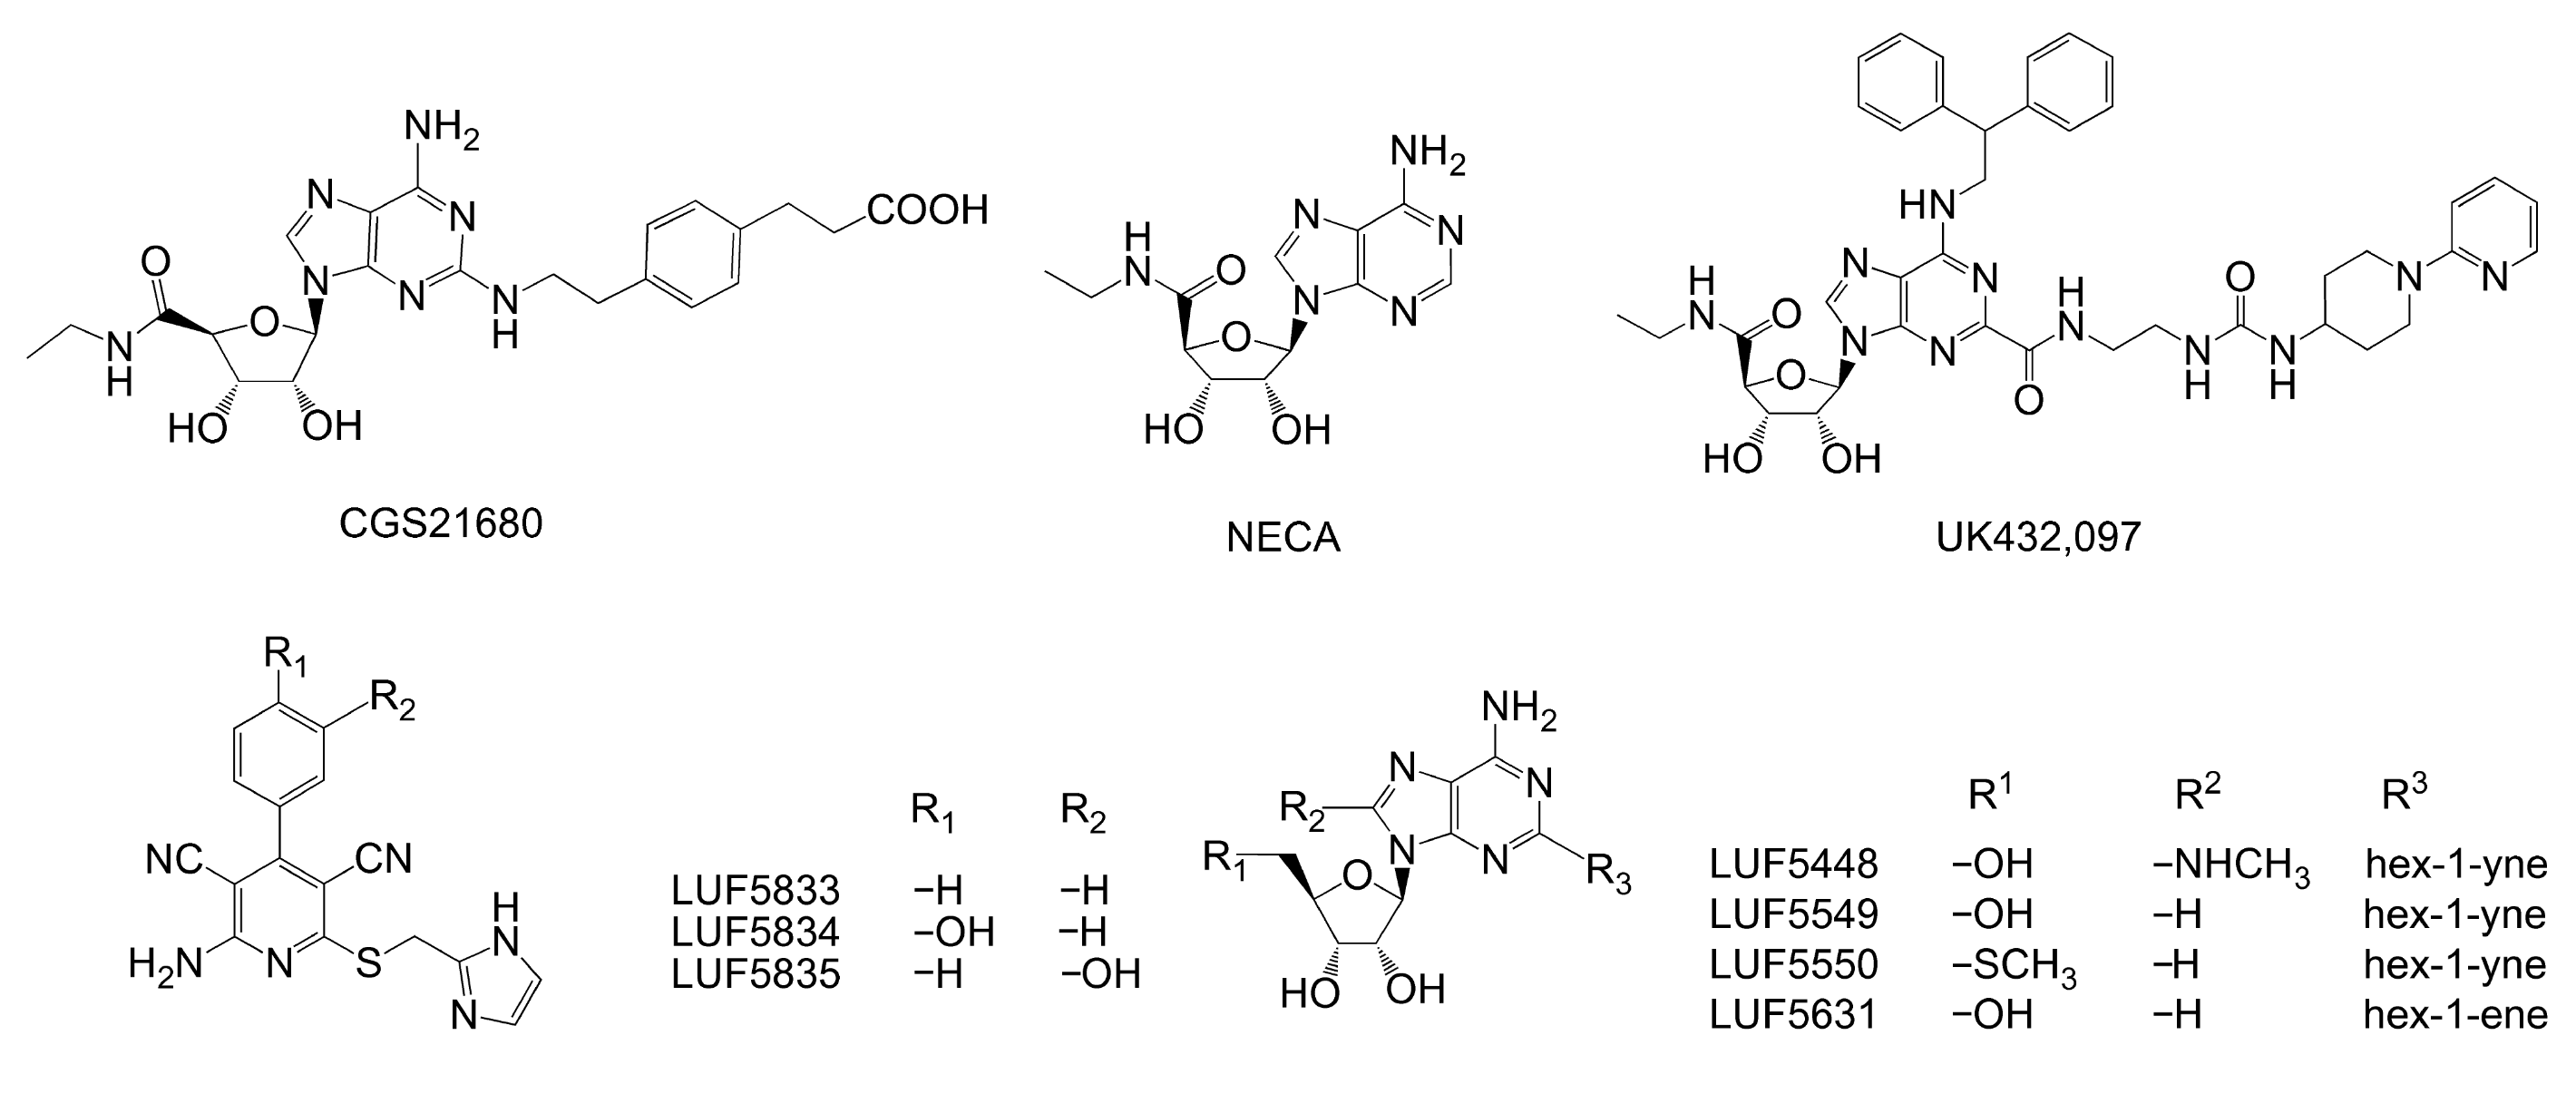

## Developing SMILES strings

--> SMILES strings define the atoms and connectivity of a molecule. SMILES strings for all ligands in PDB entries can be accessed by following the [ligands tab, e.g. for 5wf5](https://www.rcsb.org/ligand-validation/5WF5/UKA), to the [ligand summary and definition, e.g. for UKA](https://www.rcsb.org/ligand/UKA). Below you should define `known_smiles` based on the "Isomeric SMILES" field for the ligand from your Reference PDB entry.

In [12]:
known_name = "UK432097"
known_smiles = "CCNC(=O)[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2nc(nc3NCC(c4ccccc4)c5ccccc5)C(=O)NCCNC(=O)NC6CCN(CC6)c7ccccn7)O)O"

--> Now practice modifying `known_smiles` into another string. A convenient tool to do this is [PubChem](https://pubchem.ncbi.nlm.nih.gov/). You can copy and paste `known_smiles`, search, and then find the "Edit Structure" button. You should modify the ligand from the reference PDB into your assigned ligand. If your assigned ligand is in the reference PDB, modify that ligand into another analog and put the final result in the cell below.

In [13]:
analogue_name = "LUF5448"
analogue_smiles = "C([C@@H]1[C@H]([C@H]([C@@H](O1)[N]2C(=NC3=C(N=C(N=C23)CCCCC#C)N([H])[H])N([H])C)O[H])O[H])O[H]"

We need to tell Bridgeport the residue name of the ligand in the PDB file. The following command should list the names of the ligands in your template.

In [14]:
!grep HETNAM {directories['input']}/{template1_id}.pdb

HETNAM     UKA 6-(2,2-DIPHENYLETHYLAMINO)-9-[(2R,3R,4S,5S)-5-                   
HETNAM   2 UKA  (ETHYLCARBAMOYL)-3,4-DIHYDROXY-OXOLAN-2-YL]-N-[2-[(1-           
HETNAM   3 UKA  PYRIDIN-2-YLPIPERIDIN-4-YL)                                     
HETNAM   4 UKA  CARBAMOYLAMINO]ETHYL]PURINE-2-CARBOXAMIDE                       
HETNAM     OLC (2R)-2,3-DIHYDROXYPROPYL (9Z)-OCTADEC-9-ENOATE                   


--> Define `known_resname` below to the residue name of the ligand in the template that is most similar to your assigned ligand. Confirm by visualization of the structure.

In [15]:
known_resname = "UKA"

# Visualizes ligand in the binding site
import py3Dmol
view = py3Dmol.view()
view.setBackgroundColor('white')
view.addModel(open(f"{directories['input']}/{template1_id}_aligned.pdb", 'r').read(),'pdb')
view.setStyle({'resn':known_resname}, {'stick':{}})
view.zoomTo({'resn':known_resname})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [16]:
# Create a file containing coordinates of only the known ligand
!grep ' {known_resname}' {directories['input']}/{template1_id}_aligned.pdb > {directories['input']}/{known_name}_aligned.pdb
!cat {directories['input']}/{known_name}_aligned.pdb

HETATM 3464  C1  UKA A1201       3.589  -1.819   8.997  1.00 65.41           C  
HETATM 3465  N1  UKA A1201       1.989  -1.857  10.926  1.00 69.38           N  
HETATM 3466  O1  UKA A1201       1.909  -0.185   9.302  1.00 71.68           O  
HETATM 3467  C2  UKA A1201       2.588  -1.914   7.846  1.00 69.15           C  
HETATM 3468  N2  UKA A1201       0.087   0.192   6.494  1.00 62.60           N  
HETATM 3469  O2  UKA A1201       3.240  -2.099   6.595  1.00 75.42           O  
HETATM 3470  C3  UKA A1201       1.909  -0.542   7.913  1.00 69.54           C  
HETATM 3471  N3  UKA A1201       0.193  -2.873  11.823  1.00 69.22           N  
HETATM 3472  O3  UKA A1201       4.768  -1.107   8.636  1.00 80.01           O  
HETATM 3473  C4  UKA A1201       2.785  -1.029  10.026  1.00 68.21           C  
HETATM 3474  N4  UKA A1201       2.744  -3.732  14.381  1.00 70.25           N  
HETATM 3475  O4  UKA A1201      -0.226  -1.626   7.793  1.00 69.66           O  
HETATM 3476  C5  UKA A1201  

## Building an analogue

The following code uses rdkit to build models of the reference ligand and the analogue, identify maximum common substructures, and display them with the indices labeled. The indicies are helpful for aligning additional atoms.

[13:37:28] WARNING: More than one matching pattern found - picking one



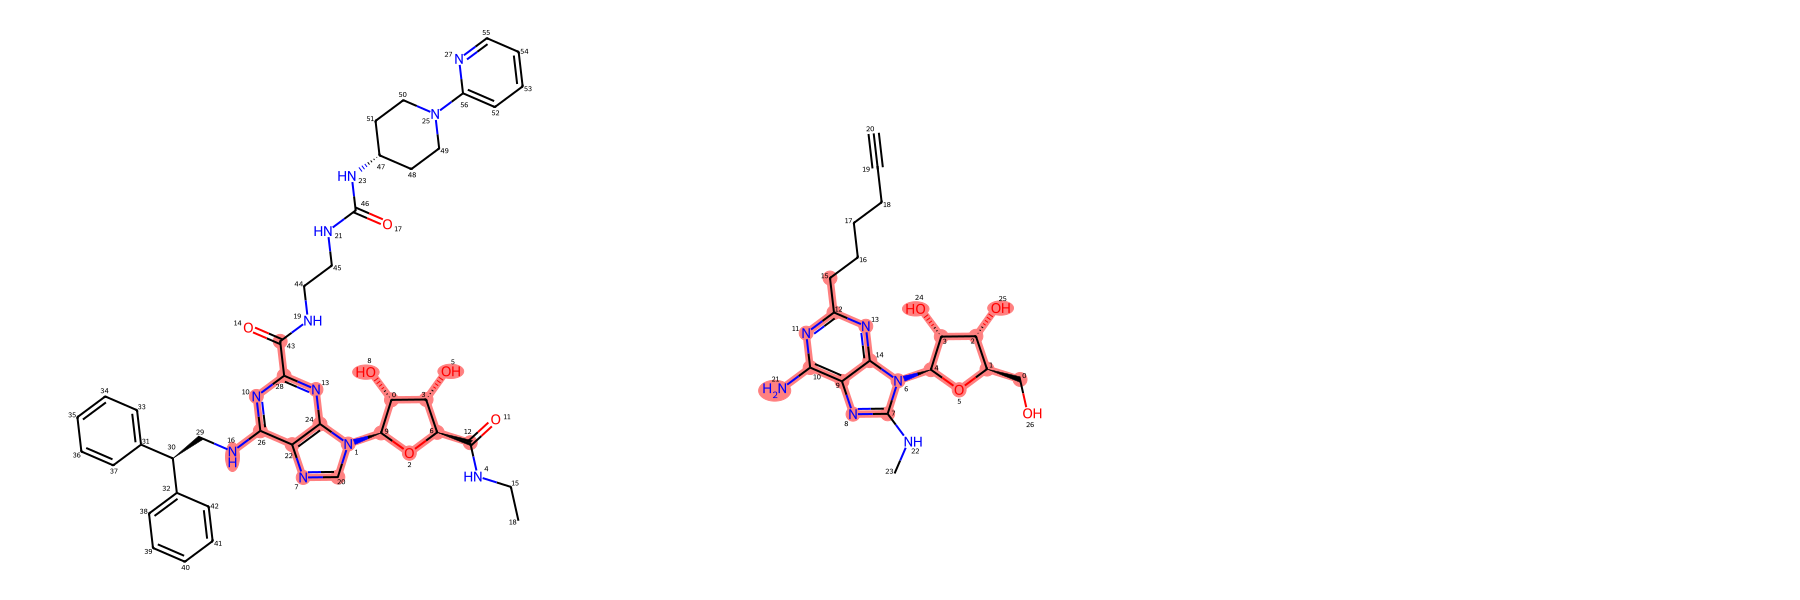

In [17]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem import rdFMCS

# Create the molecules
ref_mol = Chem.MolFromPDBFile(\
  f"{directories['input']}/{known_name}_aligned.pdb")
ref_mol = Chem.AllChem.AssignBondOrdersFromTemplate(\
  Chem.MolFromSmiles(known_smiles), ref_mol)
new_mol = Chem.MolFromSmiles(analogue_smiles)

# Find the maximum common substructure
params = rdFMCS.MCSParameters()
params.AtomCompareParameters.CompleteRingsOnly = True
params.AtomCompareParameters.MatchValences = True
params.AtomCompareParameters.RingMatchesRingOnly = True
params.BondCompareParameters.MatchFusedRingsStrict = True
mcs = rdFMCS.FindMCS([ref_mol,new_mol], params)
mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
mcs_ref_mol_inds = ref_mol.GetSubstructMatch(mcs_mol)
mcs_new_mol_inds = new_mol.GetSubstructMatch(mcs_mol)

# Create a depiction in which the chemicals are aligned by the MCS
Chem.AllChem.Compute2DCoords(mcs_mol)
Chem.AllChem.GenerateDepictionMatching2DStructure(ref_mol, mcs_mol)
Chem.AllChem.GenerateDepictionMatching2DStructure(new_mol, mcs_mol)

dopts = Chem.Draw.rdMolDraw2D.MolDrawOptions()
dopts.addAtomIndices = True

display(Chem.Draw.MolsToGridImage([ref_mol, new_mol],\
  subImgSize=(600,600),\
  highlightAtomLists=[mcs_ref_mol_inds, mcs_new_mol_inds],
  drawOptions=dopts))

--> If there are atoms that should be aligned that are not part of the maximum common substructure, modify the `analogue_atom_inds` and `known_atom_inds` lists accordingly.

In [18]:
analogue_atom_inds = [16,17,18,19,20]
known_atom_inds = [19,44,45,21,46]

known_atoms = [ref_mol.GetAtoms()[i].GetMonomerInfo().GetName().strip() for i in known_atom_inds]
known_resids = [ref_mol.GetAtoms()[i].GetPDBResidueInfo().GetResidueNumber() for i in known_atom_inds]

Chem.AllChem.EmbedMolecule(new_mol)
new_mol_pdb_block = Chem.MolToPDBBlock(new_mol)
new_mol = Chem.MolFromPDBBlock(new_mol_pdb_block)

analogue_atoms = [new_mol.GetAtoms()[i].GetMonomerInfo().GetName().strip() for i in analogue_atom_inds]

print(known_atoms)
print(analogue_atoms)

['N7', 'C28', 'C29', 'N8', 'C30']
['C12', 'C13', 'C14', 'C15', 'C16']


[13:40:59] Molecule does not have explicit Hs. Consider calling AddHs()


Generate a ligand conformation that matches the reference conformation.

10/30/2024 15:03:39//Created analogue conformer directory  bridgeport_in/LUF5448_conformers
10/30/2024 15:03:39//Created known ligand bridgeport_in/UK432097_aligned.pdb from smiles: CCNC(=O)[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2nc(nc3NCC(c4ccccc4)c5ccccc5)C(=O)NCCNC(=O)NC6CCN(CC6)c7ccccn7)O)O
10/30/2024 15:03:39//Created analogue LUF5448 from smiles: C([C@@H]1[C@H]([C@H]([C@@H](O1)[N]2C(=NC3=C(N=C(N=C23)CCCCC#C)N([H])[H])N([H])C)O[H])O[H])O[H]


[15:03:39] WARNING: More than one matching pattern found - picking one

[15:03:39] Molecule does not have explicit Hs. Consider calling AddHs()


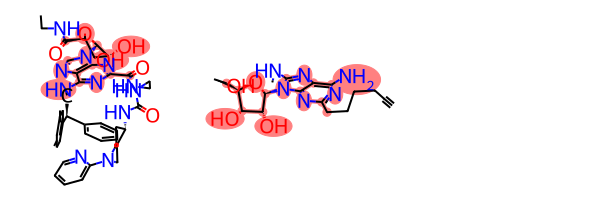

10/30/2024 15:03:40//Generating 0 conformers of analogue.
10/30/2024 15:03:40//Identified atoms to align in reference ["C5", "C3", "C2", "C1", "C4", "O1", "N1", "C8", "N3", "C9", "C10", "N5", "C12", "N4", "C11", "N6", "C27", "O3", "O2"]
10/30/2024 15:03:40//Identified resids to align in reference ["1201", "1201", "1201", "1201", "1201", "1201", "1201", "1201", "1201", "1201", "1201", "1201", "1201", "1201", "1201", "1201", "1201", "1201", "1201"]
10/30/2024 15:03:40//Identified atoms to align in analogue ["C1", "C2", "C3", "C4", "C5", "O1", "N1", "C6", "N2", "C7", "C10", "N4", "C9", "N3", "C8", "N5", "C11", "O2", "O3"]
10/30/2024 15:03:40//Identified atoms to align in reference ["C5", "C3", "C2", "C1", "C4", "O1", "N1", "C8", "N3", "C9", "C10", "N5", "C12", "N4", "C11", "N6", "C27", "O3", "O2"]
10/30/2024 15:03:40//Identified atoms to adjust torsions in reference  ["C5", "C3", "C2", "C1", "C4", "O1", "N1", "C8", "N3", "C9", "C10", "N5", "C12", "N4", "C11", "N6", "C27", "O3", "O2", "N7"

[15:03:40] Molecule does not have explicit Hs. Consider calling AddHs()


10/30/2024 15:03:40//Changed ['C7' 'C10' 'N1' 'C5'] (3.1414028836633907) to match ['C9', 'C10', 'N1', 'C4'] (3.0810465221112615)
10/30/2024 15:03:40//Changed ['N4' 'C10' 'C7' 'N2'] (-3.141534596267409) to match ['N5', 'C10', 'C9', 'N3'] (-3.131578521479999)
10/30/2024 15:03:40//Could not change ['C17' 'N6' 'C6' 'N1'] to match ['X', 'X', 'C8', 'N1']
10/30/2024 15:03:40//Changed ['C8' 'C7' 'C10' 'N1'] (-0.00011533252752649048) to match ['C11', 'C9', 'C10', 'N1'] (-3.1061546174194694)
10/30/2024 15:03:40//Changed ['C9' 'N4' 'C10' 'C7'] (-0.0008273108473004775) to match ['C12', 'N5', 'C10', 'C9'] (0.004892120685429457)
10/30/2024 15:03:40//Changed ['N3' 'C8' 'C7' 'C10'] (-0.00022992529823762098) to match ['N4', 'C11', 'C9', 'C10'] (-0.035548268862499934)
10/30/2024 15:03:40//Changed ['N5' 'C8' 'C7' 'C10'] (-3.1408808756594446) to match ['N6', 'C11', 'C9', 'C10'] (3.037494461452799)
10/30/2024 15:03:40//Changed ['C11' 'C9' 'N3' 'C8'] (-3.1412571581215847) to match ['C27', 'C12', 'N4', 'C11'

In [51]:
from Bridgeport.utils.bp_utils import analogue_alignment

analogue_alignment(smiles=analogue_smiles, \
  known_pdb = f"{directories['input']}/{known_name}_aligned.pdb", \
  known_resids = known_resids, \
  known_smiles = known_smiles, \
  analogue_atoms = analogue_atoms, \
  known_atoms = known_atoms, \
  analogue_out_path = f"{directories['input']}/{analogue_name}.pdb", \
  rmsd_thres=2.0, n_conformers=0)
!cp {directories['input']}/{analogue_name}_conformers/{analogue_name}_0.pdb {directories['input']}/{analogue_name}_aligned.pdb

In [52]:
# Visualizes ligands
view = py3Dmol.view()
view.setBackgroundColor('white')
view.addModel(open(f"{directories['input']}/{known_name}_aligned.pdb", 'r').read(),'pdb')
view.addModel(open(f"{directories['input']}/{analogue_name}_aligned.pdb", 'r').read(),'pdb')
view.setStyle({'model':0}, {'stick': {'colorscheme':'blueCarbon'}})
view.setStyle({'model':1}, {'stick': {'colorscheme':'yellowCarbon'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

--> Describe your confidence in the model of the analog.

--> Choose the `ligand_name` below, depending on whether your ligand is in the PDB file is or a close analog. Comment out the other one.

In [21]:
# ligand_name = known_name
# ligand_name = known_smiles
# ligand_resname = known_resname

ligand_name = analogue_name
ligand_smiles = analogue_smiles
ligand_resname = 'UNL'

In [53]:
# Create a file containing the coordinates of the receptor-ligand complex
complex_FN = f"{directories['input']}/{receptor_name}-{ligand_name}.pdb"
!cat {directories['input']}/{receptor_name}_aligned.pdb {directories['input']}/{ligand_name}_aligned.pdb > {complex_FN}

# Remove END line
F = open(complex_FN,'r')
lines = [line.strip() for line in F.readlines() if line.startswith('ATOM') or line.startswith('HETATM')]
F.close()
F = open(complex_FN,'w')
F.write('\n'.join(lines))
F.close()

# Part III - Building the membrane and solvent environment

Often, molecular systems are simulated in a box filled with solvent such as water. These boxes are of finite size, which results in problems for molecules at or near the box boundaries. With which molecules should those interact? Periodic boundary conditions can avoid such boundary artifacts by simulating a theoretically infinite system. Molecules at one boundary of the box thereby interact with molecules at the boundary on the other side of the box. This mimics a situation, in which the simulation box is surrounded by replicas of itself. When visualizing such MD simulations, one can often observe that particles leave the box at one side (Fig. 3). However, they re-appear at the same time on the other side of the box with the same velocity. For simulations under periodic boundary conditions, it is recommended to use a simulation box large enough, so that the simulated macromolecule does not come into contact with neighboring images of itself.

![MD_water.gif](https://github.com/volkamerlab/teachopencadd/raw/d1ded86bb2c82ef088cc5145d0bcb997f6eab7dd/teachopencadd/talktorials/018_md_simulation/images/MD_water.gif)

**Figure 3**: Molecular dynamics simulation of water molecules with periodic boundary conditions (Kmckiern via [Wikimedia](https://commons.wikimedia.org/wiki/File:MD_water.gif)).

We will use Bridgeport to build the solvent and membrane environment. The following code writes a configuration file for Bridgeport, creates an Bridgeport instance, and builds the environment.

In [23]:
prep_json = {
    "working_dir": directories['working'],

    "protein": {
        "input_pdb_dir": directories['input'],
        "input_pdb": f"{receptor_name}-{ligand_name}.pdb",
        "chains": "A"
    },

    "RepairProtein": {
        "working_dir": False,
        "fasta_path": f"{directories['input']}/ADORA2A.fasta",
        "tails": False,
        "loops": False,
        "secondary_template": False
    },

    "ligand":{
        "lig_resname": ligand_resname,
        "known_smiles": ligand_smiles,
        "peptide_chain": False,
        "peptide_fasta": False
    },

    "environment": {
        "membrane": True,
        "alignment_ref": f"{directories['input']}/{opm_id}.pdb",
        "alignment_chains": "A"
    }
}

import json
prep_json_fn = f"{directories['input']}/prep_{receptor_name}-{ligand_name}.json"
F = open(prep_json_fn,'w')
F.write(json.dumps(prep_json, indent=4))
F.close()

In [54]:
!cp {directories['input']}/{receptor_name}-{ligand_name}.pdb {directories['working']}/aligned_input_pdb/{receptor_name}-{ligand_name}.pdb

from Bridgeport import Bridgeport
BP = Bridgeport.Bridgeport(input_json=prep_json_fn)

BP._separate_lig_prot()

10/30/2024 15:04:47//Welcome to Bridgeport.
10/30/2024 15:04:47//Found input parameters.
10/30/2024 15:04:47//working_dir:
10/30/2024 15:04:47//working_dir: bridgeport_working
10/30/2024 15:04:47//protein:
10/30/2024 15:04:47//	input_pdb_dir: bridgeport_in
10/30/2024 15:04:47//	input_pdb: ADORA2A-LUF5448.pdb
10/30/2024 15:04:47//	chains: A
10/30/2024 15:04:47//RepairProtein:
10/30/2024 15:04:47//	working_dir: False
10/30/2024 15:04:47//	fasta_path: bridgeport_in/ADORA2A.fasta
10/30/2024 15:04:47//	tails: False
10/30/2024 15:04:47//	loops: False
10/30/2024 15:04:47//	secondary_template: False
10/30/2024 15:04:47//ligand:
10/30/2024 15:04:47//	lig_resname: UNL
10/30/2024 15:04:47//	known_smiles: C([C@@H]1[C@H]([C@H]([C@@H](O1)[N]2C(=NC3=C(N=C(N=C23)CCCCC#C)N([H])[H])N([H])C)O[H])O[H])O[H]
10/30/2024 15:04:47//	peptide_chain: False
10/30/2024 15:04:47//	peptide_fasta: False
10/30/2024 15:04:47//environment:
10/30/2024 15:04:47//	membrane: True
10/30/2024 15:04:47//	alignment_ref: bridgepo

In [38]:
pdb_fn = BP.input_params['protein']['input_pdb']
pdb_path = os.path.join(BP.prot_only_dir, pdb_fn)

from ProteinPreparer import ProteinPreparer
pp = ProteinPreparer(pdb_path=pdb_path,
                      working_dir=BP.prot_only_dir,
                      pH=7.0,
                      env='MEM',
                      ion_strength=0.15)

from datetime import datetime
# Protonate (with pdb2pqr30 which also adds missing atoms, but not missing residues)
print(datetime.now().strftime("%m/%d/%Y %H:%M:%S") + '//Protonating protein with pdb2pqr30', flush=True)
pp.H_pdb = pp._protonate_with_pdb2pqr(at_pH=pp.pH)

# Check completion
if os.path.exists(pp.H_pdb):
    print(datetime.now().strftime("%m/%d/%Y %H:%M:%S") + '//Output written to:', pp.H_pdb, flush=True)

10/30/2024 13:54:16//Welcome to ProteinPreparer
10/30/2024 13:54:16//Protonating protein with pdb2pqr30
Protanting using command line
Running pdb2pqr30 --ff AMBER --nodebump --keep-chain --ffout AMBER --pdb-output bridgeport_working/proteins/ADORA2A-LUF5448_H.pdb --with-ph 7.0 bridgeport_working/proteins/ADORA2A-LUF5448.pdb bridgeport_working/proteins/ADORA2A-LUF5448.pqr
10/30/2024 13:54:21//Output written to: bridgeport_working/proteins/ADORA2A-LUF5448_H.pdb


In [48]:
# Adds a CRYST1 line so that trim_env doesn't complain
with open(pp.H_pdb,'r') as F:
  dat = F.read()
with open(pp.H_pdb,'w') as F:
  F.write('CRYST1\n')
  F.write(dat)

from Bridgeport.utils.bp_utils import trim_env
trim_env(pp.H_pdb) # Measures appropriate box size

#Create Environment
print(datetime.now().strftime("%m/%d/%Y %H:%M:%S") + '//Creating environment with pdbfixer', flush=True)
pp._run_PDBFixer(mode=pp.env, padding=1.5, ionicStrength=pp.ion)

# Check completion
if os.path.exists(pp.env_pdb):
    print(datetime.now().strftime("%m/%d/%Y %H:%M:%S") + '//Output written to:', pp.env_pdb, flush=True)

# Trim
# print(datetime.now().strftime("%m/%d/%Y %H:%M:%S") + '//Trimming', pp.env_pdb, 'with padding of 15 Angstroms.', flush=True)
# trim_env(pp.env_pdb, 15)

10/30/2024 14:39:21//Identified new box size: [ 98.402  69.084 111.313]
10/30/2024 14:39:21//Writing new CRYST1 line: CRYST1   98.402   69.084  111.313  90.00  90.00  90.00 P 1           
10/30/2024 14:39:21//Identified  0 atoms to remove.
10/30/2024 14:39:21//Identified  0 resids to remove.
10/30/2024 14:39:21//Untrimmed no. of atoms: 5066
10/30/2024 14:39:21//Trimmed no. of atoms: 5066
10/30/2024 14:39:21//Trimmed environment saved to: bridgeport_working/proteins/ADORA2A-LUF5448_H.pdb
10/30/2024 14:39:21//Creating environment with pdbfixer
10/30/2024 14:51:26//Output written to: bridgeport_working/proteins/ADORA2A-LUF5448_env.pdb


# Part IV - Force field setup

We can now use the coordinates of the complex to set up the molecular mechanics force field.

Force fields describe the forces between atoms within and between molecules. They are parametric equations with components for different forces (bond stretching, van-der-Waals and more). The parameter values are usually derived experimentally and change for each MD scenario, depending on the molecules involved and the simulation settings. The result is a mathematical description of the energy landscape of the system, in which the forces acting on each particle result from the gradient of the potential energy with respect to the coordinates of the atoms.

Several force fields are available, each with its own characteristics ([_J Chem Inf Model_ (2018), **58**(3), 565-578](https://doi.org/10.1021/acs.jcim.8b00042)). In this notebook, we will use a member of the AMBER force field family, which are widely used for modeling proteins. Their functional form is:

$$V(r^N) = \sum_{i \in  bonds}k_{bi} (l_i-l^0_i)^2 + \sum_{i \in  angles}k_{ai}(\theta_i - \theta^0_i)^2 + \sum_{i\in torsions} \sum_n \frac{1}{2} V_i^n[1+cos(nw_i-\gamma_i)]$$
$$+ \sum_{j=1}^{N-1}\sum_{I=j+1}^{N} f_{ij}\in ij [(\frac{r^0_{ij}}{r_{ij}})^{12}-2(\frac{r^0_{ij}}{r_{ij}})^{6}]+\frac{q_iq_j}{4\pi \in_0 r_{ij}}$$

The formula consists of a sum of different components. The first three components contain information about bond lengths, angles and torsions (intramolecular forces). The last component describes intermolecular, non-bonded forces like van-der-Waals forces and electrostatic interactions. The various parameters, denoted by a superscript 0, depend on the force field used and vary between all members of the AMBER force field family. Note that these force fields assume fixed-charge particles and do not allow polarization, nor do they consider how a local charge influences its surroundings.

The following visual representation of force fields components shows the same concepts in a more intuitive way.

![MM_PEF.png](https://github.com/volkamerlab/teachopencadd/raw/d1ded86bb2c82ef088cc5145d0bcb997f6eab7dd/teachopencadd/talktorials/018_md_simulation/images/MM_PEF.png)

**Figure 2**: Components of a molecular mechanics force field (Edboas via [Wikimedia](https://commons.wikimedia.org/w/index.php?curid=4194424)).

Common force fields like AMBER have parameters for amino acids, nucleic acids, water and ions and usually offer several options to choose from depending on your aim. We will use AMBER for protein, water, and membrane and the OpenFF forcefield for ligands. The following code will assign parameters to all the atoms in the system. It can take a while.

In [55]:
BP._ligand_prep()
BP._generate_systems()

10/30/2024 15:05:03//Found small molecule ligand with resname: UNL
10/30/2024 15:05:03//Saved prepared ligand to bridgeport_working/ligands/ADORA2A-LUF5448.pdb bridgeport_working/ligands/ADORA2A-LUF5448.sdf
10/30/2024 15:05:03//Saved prepared ligand to bridgeport_working/ligands/ADORA2A-LUF5448.pdb
10/30/2024 15:05:03//Created systems directory: bridgeport_working/systems
10/30/2024 15:05:03//Building parameters for ADORA2A-LUF5448


[15:05:03] Molecule does not have explicit Hs. Consider calling AddHs()


10/30/2024 15:05:29//Protein parameters built.
10/30/2024 15:12:03//Ligand parameters built.
10/30/2024 15:12:07//System parameters built.
10/30/2024 15:12:09//Initial structure potential energy: -2480530.76
10/30/2024 15:12:28//Final system coordinates saved to bridgeport_working/systems/ADORA2A-LUF5448.pdb
10/30/2024 15:12:28//Final system parameters saved to bridgeport_working/systems/ADORA2A-LUF5448.xml


# Saving data

--> We don't want to lose all of this work! Modify the `directories['destination']` to point to the shared folder on your Google Drive. The following code should copy your model (.pdb) and OpenMM system (.xml) to the destination directory on your Google Drive.

In [56]:
directories['destination'] = '/content/drive/MyDrive/Classes/Chem 456 2024F/students/dminh/exercises/06-System_Preparation'

import shutil
shutil.copy(os.path.join(directories['working'], 'proteins', f'{receptor_name}-{ligand_name}_env.pdb'), \
            os.path.join(directories['destination'], f'{receptor_name}-{ligand_name}_env.pdb'))
shutil.copy(os.path.join(directories['working'], 'systems', f'{receptor_name}-{ligand_name}.pdb'), \
            os.path.join(directories['destination'], f'{receptor_name}-{ligand_name}.pdb'))
shutil.copy(os.path.join(directories['working'], 'systems', f'{receptor_name}-{ligand_name}.xml'), \
            os.path.join(directories['destination'], f'{receptor_name}-{ligand_name}.xml'))

'/content/drive/MyDrive/Classes/Chem 456 2024F/students/dminh/exercises/06-System_Preparation/ADORA2A-LUF5448.xml'

# References

- Review on force fields ([_J Chem Inf Model_ (2018), **58**(3), 565-578](https://doi.org/10.1021/acs.jcim.8b00042))
- Summarized statistical knowledge from Pierre-Simon Laplace ([Théorie Analytique des Probabilités _Gauthier-Villars_ (1820), **3**)](https://archive.org/details/uvrescompltesde31fragoog/page/n15/mode/2up)
- Inspired by a notebook form Jaime Rodríguez-Guerra ([github](https://github.com/jaimergp/uab-msc-bioinf/blob/master/MD%20Simulation%20and%20Analysis%20in%20a%20Notebook.ipynb))
- Repositories of [OpenMM](https://github.com/openmm/openmm) and [OpenMM Forcefields](https://github.com/openmm/openmmforcefields), [RDKit](https://github.com/rdkit/rdkit), [PyPDB](https://github.com/williamgilpin/pypdb), [MDTraj](https://github.com/mdtraj/mdtraj), [PDBFixer](https://github.com/openmm/pdbfixer)
- Wikipedia articles about [AMBER](https://en.wikipedia.org/wiki/AMBER) and [force fields](https://en.wikipedia.org/wiki/Force_field_(chemistry)) in general